<a href="https://colab.research.google.com/github/ecsquare/Deep-Compression-with-autoencoder/blob/master/Compression_with_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

Load the MNIST Dataset

In [0]:
from keras.datasets import mnist
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [157]:
X_train.shape

(60000, 28, 28)

In [158]:
X_test.shape

(10000, 28, 28)

In [0]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
# Normalisation
X_train /= 255
X_test /= 255

<h1> 1.Salt&pepper noise </h1>
Salt-and-pepper noise is a form of noise sometimes seen on images. It is also known as impulse noise. This noise can be caused by sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels. An effective noise reduction method for this type of noise is a median filter or a morphological filter.For reducing either salt noise or pepper noise, but not both, a contraharmonic mean filter can be effective.



In [0]:
def saltpepper_noise(arr,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(784)
    thres = 1 - prob 
    for i in range(784):
        rdn = random.random()
        if rdn < prob:
          output[i] = 0
        elif rdn > thres:
          output[i] = 1
        else:
          output[i] = arr[i]
    return output

In [0]:
a=sp_noise(X_train[0],0.2)

In [0]:
def prepare_data_salt_pepper(data,prob):
  output = np.zeros(data.shape)
  for i in range(len(data)):
    output[i]=saltpepper_noise(data[i],prob)
  return output

In [0]:
X_train_salt_pepper=prepare_data_salt_pepper(X_train,0.01)
X_test_salt_pepper=prepare_data_salt_pepper(X_test,0.01)

Let's see some dataset elements before and after noise 


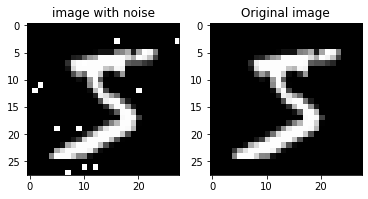

In [78]:
plt.subplot(121)
plt.imshow(X_train_salt_pepper[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title("image with noise")
 
 
plt.subplot(122)
plt.imshow(X_train[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title("Original image")

# Show the graph
plt.show()

<h1> 2.Speckle noise </h1>
Speckle noise is defined as multiplicative noise, having a granular pattern it is the inherent property of SAR image. Synthetic Aperture Radar (SAR) imagery uses microwave radiation so that it can illuminate the earth surface. Synthetic Aperture Radar provides its own illumination.

In [0]:
def speckle_noise(arr):
      gauss = np.random.randn(784)      
      noisy = arr + arr * gauss
      return noisy

3.8098192441612104


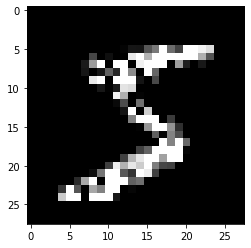

In [97]:
a=speckle_noise(X_train[0])
plt.imshow(a.reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
print(a.max())


In [0]:
def prepare_data_speckle(data):
  output = np.zeros(data.shape)
  for i in range(len(data)):
    output[i]=speckle_noise(data[i])
    m=output[i].max()
    output[i]=output[i]/m
  return output

In [0]:
X_train_speckle=prepare_data_speckle(X_train)
X_test_speckle=prepare_data_speckle(X_test)

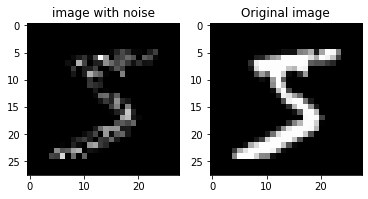

In [109]:
plt.subplot(121)
plt.imshow(X_train_speckle[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title("image with noise")
 
 
plt.subplot(122)
plt.imshow(X_train[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title("Original image")

# Show the graph
plt.show()

<h1> 3.Build Deep autoencoder <h1>

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [0]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)


<h2> 3.1-Training on original dataset </h2>




In [162]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/checks_autoencoder/model-{epoch:02d}.hdf5', verbose=1)
callbacks_list=[checkpointer]
autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=callbacks_list)



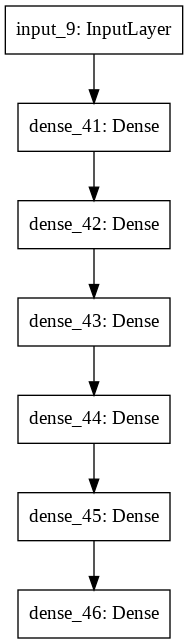

In [177]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png')

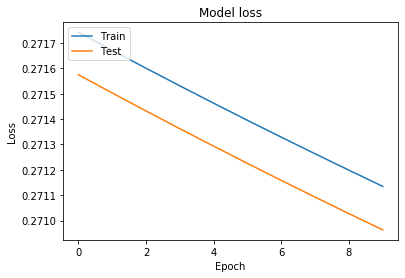

In [178]:
# Plot training & validation accuracy values
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

AttributeError: ignored

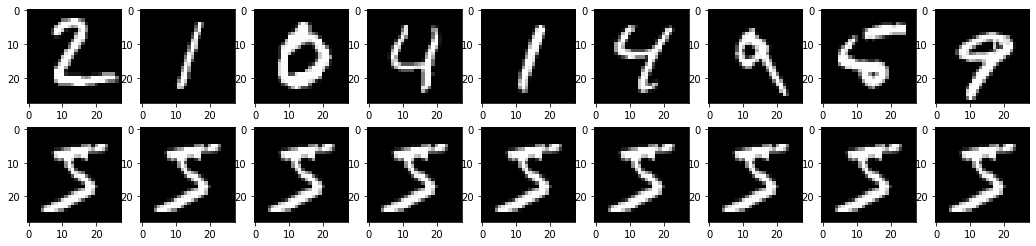

In [164]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)


    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(X_train[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
   
plt.show()

<h2> 3.2-Training on noisy dataset(salt&pepper)</h2>


In [0]:
autoencoder_salt_pepper = Model(input_img, decoded)
autoencoder_salt_pepper.compile(optimizer='adadelta', loss='binary_crossentropy')
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/checks_autoencoder_salt_pepper/model-{epoch:02d}.hdf5', verbose=1)
callbacks_list=[checkpointer]
autoencoder.fit(X_train_salt_pepper, X_train_salt_pepper,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_salt_pepper, X_test_salt_pepper),
                callbacks=callbacks_list)


In [0]:
decoded_imgs2 = autoencoder_salt_pepper.predict(X_test_salt_pepper)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_salt_pepper[i].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)


    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(X_train_salt_pepper[0].reshape(28, 28), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
   
plt.show()

<h2> 3.3-Training on noisy dataset (speckle) </h2>


In [0]:
autoencoder_salt_pepper = Model(input_img, decoded)
autoencoder_salt_pepper.compile(optimizer='adadelta', loss='binary_crossentropy')
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/checks_autoencoder_salt_pepper/model-{epoch:02d}.hdf5', verbose=1)
callbacks_list=[checkpointer]
autoencoder.fit(X_train_salt_pepper, X_train_salt_pepper,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_salt_pepper, X_test_salt_pepper),
                callbacks=callbacks_list)